# Part II: WGAN

In [ ]:
import torch as t
from torch import nn
from torch.autograd import Variable
from torch.optim import RMSprop
from torchvision import transforms
from torchvision.utils import make_grid
from torchvision.datasets import CIFAR10
from pylab import plt
%matplotlib inline

In [ ]:
import os
os.environ['CUDA_VISIBLE_DEVICES']='1'

In [ ]:
class Config:
    lr = 0.00005
    nz = 100 # noise dimension
    image_size = 64
    image_size2 = 64
    nc = 3 # chanel of img 
    ngf = 64 # generate channel
    ndf = 64 # discriminative channel
    beta1 = 0.5
    batch_size = 32
    max_epoch = 50 # =1 when debug
    workers = 2
    gpu = True # use gpu or not
    clamp_num=0.01# WGAN clip gradient
    
opt=Config()

In [ ]:
# data preprocess
transform=transforms.Compose([
                transforms.Resize(opt.image_size) ,
                transforms.ToTensor(),
                transforms.Normalize([0.5]*3,[0.5]*3)
                ])

dataset=CIFAR10(root='cifar10/',transform=transform,download=True)
# dataloader with multiprocessing
dataloader=t.utils.data.DataLoader(dataset,
                                   opt.batch_size,
                                   shuffle = True,
                                   num_workers=opt.workers)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting cifar10/cifar-10-python.tar.gz to cifar10/


In [ ]:
netg = nn.Sequential(
            nn.ConvTranspose2d(opt.nz,opt.ngf*8,4,1,0,bias=False),
            nn.BatchNorm2d(opt.ngf*8),
            nn.ReLU(True),
            
            nn.ConvTranspose2d(opt.ngf*8,opt.ngf*4,4,2,1,bias=False),
            nn.BatchNorm2d(opt.ngf*4),
            nn.ReLU(True),
            
            nn.ConvTranspose2d(opt.ngf*4,opt.ngf*2,4,2,1,bias=False),
            nn.BatchNorm2d(opt.ngf*2),
            nn.ReLU(True),
            
            nn.ConvTranspose2d(opt.ngf*2,opt.ngf,4,2,1,bias=False),
            nn.BatchNorm2d(opt.ngf),
            nn.ReLU(True),
            
            nn.ConvTranspose2d(opt.ngf,opt.nc,4,2,1,bias=False),
            nn.Tanh()
        )

netd = nn.Sequential(
            nn.Conv2d(opt.nc,opt.ndf,4,2,1,bias=False),
            nn.LeakyReLU(0.2,inplace=True),
            
            nn.Conv2d(opt.ndf,opt.ndf*2,4,2,1,bias=False),
            nn.BatchNorm2d(opt.ndf*2),
            nn.LeakyReLU(0.2,inplace=True),
            
            nn.Conv2d(opt.ndf*2,opt.ndf*4,4,2,1,bias=False),
            nn.BatchNorm2d(opt.ndf*4),
            nn.LeakyReLU(0.2,inplace=True),
            
            nn.Conv2d(opt.ndf*4,opt.ndf*8,4,2,1,bias=False),
            nn.BatchNorm2d(opt.ndf*8),
            nn.LeakyReLU(0.2,inplace=True),
            
            nn.Conv2d(opt.ndf*8,1,4,1,0,bias=False),
            # Modification 1: remove sigmoid
            # nn.Sigmoid()
        )
def weight_init(m):
    # weight_initialization: important for wgan
    class_name=m.__class__.__name__
    if class_name.find('Conv')!=-1:
        m.weight.data.normal_(0,0.02)
    elif class_name.find('Norm')!=-1:
        m.weight.data.normal_(1.0,0.02)
#     else:print(class_name)

netd.apply(weight_init)
netg.apply(weight_init)

Sequential(
  (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
  (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): ReLU(inplace=True)
  (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (8): ReLU(inplace=True)
  (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (11): ReLU(inplace=True)
  (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (13): Tanh()
)

In [ ]:
# modification 2: Use RMSprop instead of Adam
# optimizer
optimizerD = RMSprop(netd.parameters(),lr=opt.lr ) 
optimizerG = RMSprop(netg.parameters(),lr=opt.lr )  

# modification3: No Log in loss
# criterion
# criterion = nn.BCELoss()

fix_noise = Variable(t.FloatTensor(opt.batch_size,opt.nz,1,1).normal_(0,1))
if opt.gpu:
    fix_noise = fix_noise.cuda()
    netd.cuda()
    netg.cuda()

In [ ]:
one=t.FloatTensor([1])
mone=-1*one

for epoch in range(50):
    for ii, data in enumerate(dataloader,0):
        real,_=data
        input = Variable(real)
        noise = t.randn(input.size(0),opt.nz,1,1)
        noise = Variable(noise)
        
        if opt.gpu:
            one = one.cuda()
            mone = mone.cuda()
            noise = noise.cuda()
            input = input.cuda()

        # modification: clip param for discriminator
        for parm in netd.parameters():
                parm.data.clamp_(-opt.clamp_num,opt.clamp_num)
        
        # ----- train netd -----
        netd.zero_grad()
        ## train netd with real img
        output=netd(input)
        output.backward(one)
        ## train netd with fake img
        fake_pic=netg(noise).detach()
    ws    output2=netd(fake_pic)
        output2.backward(mone)
        optimizerD.step()

        print(output2.item())

        
        
        # ------ train netg -------
        # train netd more: because the better netd is,
        # the better netg will be
        if (ii+1)%5 ==0:
            netg.zero_grad()
            noise.data.normal_(0,1)
            fake_pic=netg(noise)
            output=netd(fake_pic)
            output.backward(one)
            optimizerG.step()
            if ii%100==0:pass
    fake_u=netg(fix_noise)
    imgs = make_grid(fake_u.data*0.5+0.5).cpu() # CHW
    plt.imshow(imgs.permute(1,2,0).numpy()) # HWC
    plt.show()


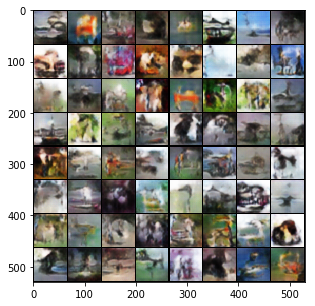

In [ ]:
noise = t.randn(64,opt.nz,1,1).cuda()
noise = Variable(noise)
fake_u=netg(noise)
imgs = make_grid(fake_u.data*0.5+0.5).cpu() # CHW
plt.figure(figsize=(5,5))
plt.imshow(imgs.permute(1,2,0).numpy()) # HWC
plt.show()